# Implementation of Bayesian Optimization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Function to optimize
def F(X, noise=0.2):
  return (np.power(X, 2))*np.sin(X) - (3*X*np.cos(X)) + noise*np.random.randn(*X.shape)

In [ ]:
rng = np.random.RandomState(0)
bounds = np.array([[-4, 4]])
x_space = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)
n_iter = 10
noise = 0.2

### Plotting the objective function

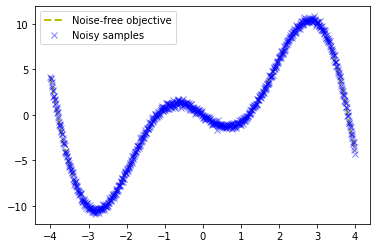

In [ ]:
plt.plot(x_space, F(x_space, 0), 'y--', lw=2, label='Noise-free objective')
plt.plot(x_space, F(x_space), 'bx', lw=1, alpha=0.5, label='Noisy samples')
plt.legend();
plt.show()

### Expected improvement as the acquisition function

In [ ]:
from scipy.stats import norm

def expected_improvement(X, X_samples, Y_samples, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_samples = gpr.predict(X_samples)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model, otherwise use np.max(Y_sample).
    mu_samples_opt = np.max(mu_samples)

    with np.errstate(divide='warn'):
        imp = mu - mu_samples_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [ ]:
# Find the next sample by maximizing the acquisition function
from scipy.optimize import minimize

def form_minimization_objective(max_obj, *params):
  def min_obj(x):
    return -max_obj(x.reshape(-1, 1), *params)

  return min_obj


def propose_next_sample(acquisition, X_samples, Y_samples, gpr, bounds, n_restarts=25):
  '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_samples: Sample locations (n x d).
        Y_samples: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
  '''
  dim = X_samples.shape[1]
  initial_points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim))
  min_val = 1e6
  min_point = None

  for point in initial_points:
    res = minimize(form_minimization_objective(acquisition, X_samples, Y_samples, gpr), x0=point, bounds=bounds, method='L-BFGS-B')
    if res.fun[0] < min_val:
      min_val = res.fun[0]
      min_point = res.x
      
  return min_point.reshape(-1, 1)

### Plotting utils

In [ ]:
def plot_acquisition_fxn(x_space, vals, X_next, show_legend=False):
  plt.plot(x_space, vals, 'r--', lw=2, label='Acquisition Function')
  plt.axvline(x=X_next, color='black', ls=':', lw=2, label='Argmax point')

  if show_legend:
    plt.legend()

In [ ]:
def plot_gaussian_process(gpr, x_space, Y, X_samples, Y_samples, show_legend=False):
  y_mean, y_std = gpr.predict(x_space, return_std=True)

  plt.plot(x_space, y_mean, 'b-', lw=1, label='Surrogate Function')
  plt.fill_between(x_space.ravel(), y_mean.ravel() - y_std, y_mean.ravel() + y_std, alpha=0.1)
  plt.plot(x_space, Y, 'y--', lw=1, label='Noise free objective function')
  plt.plot(X_samples, Y_samples, 'kx', mew=3, label='Noisy samples')

  if show_legend:
    plt.legend()

### Gaussian Process as surrogate model

In [ ]:
# import from sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# instantiate an object of Gaussian Process
# kernel = RationalQuadratic()+WhiteKernel()
kernel = 1.0*RBF() + 1.0*WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.05, n_restarts_optimizer=10)

### Main loop for iterating

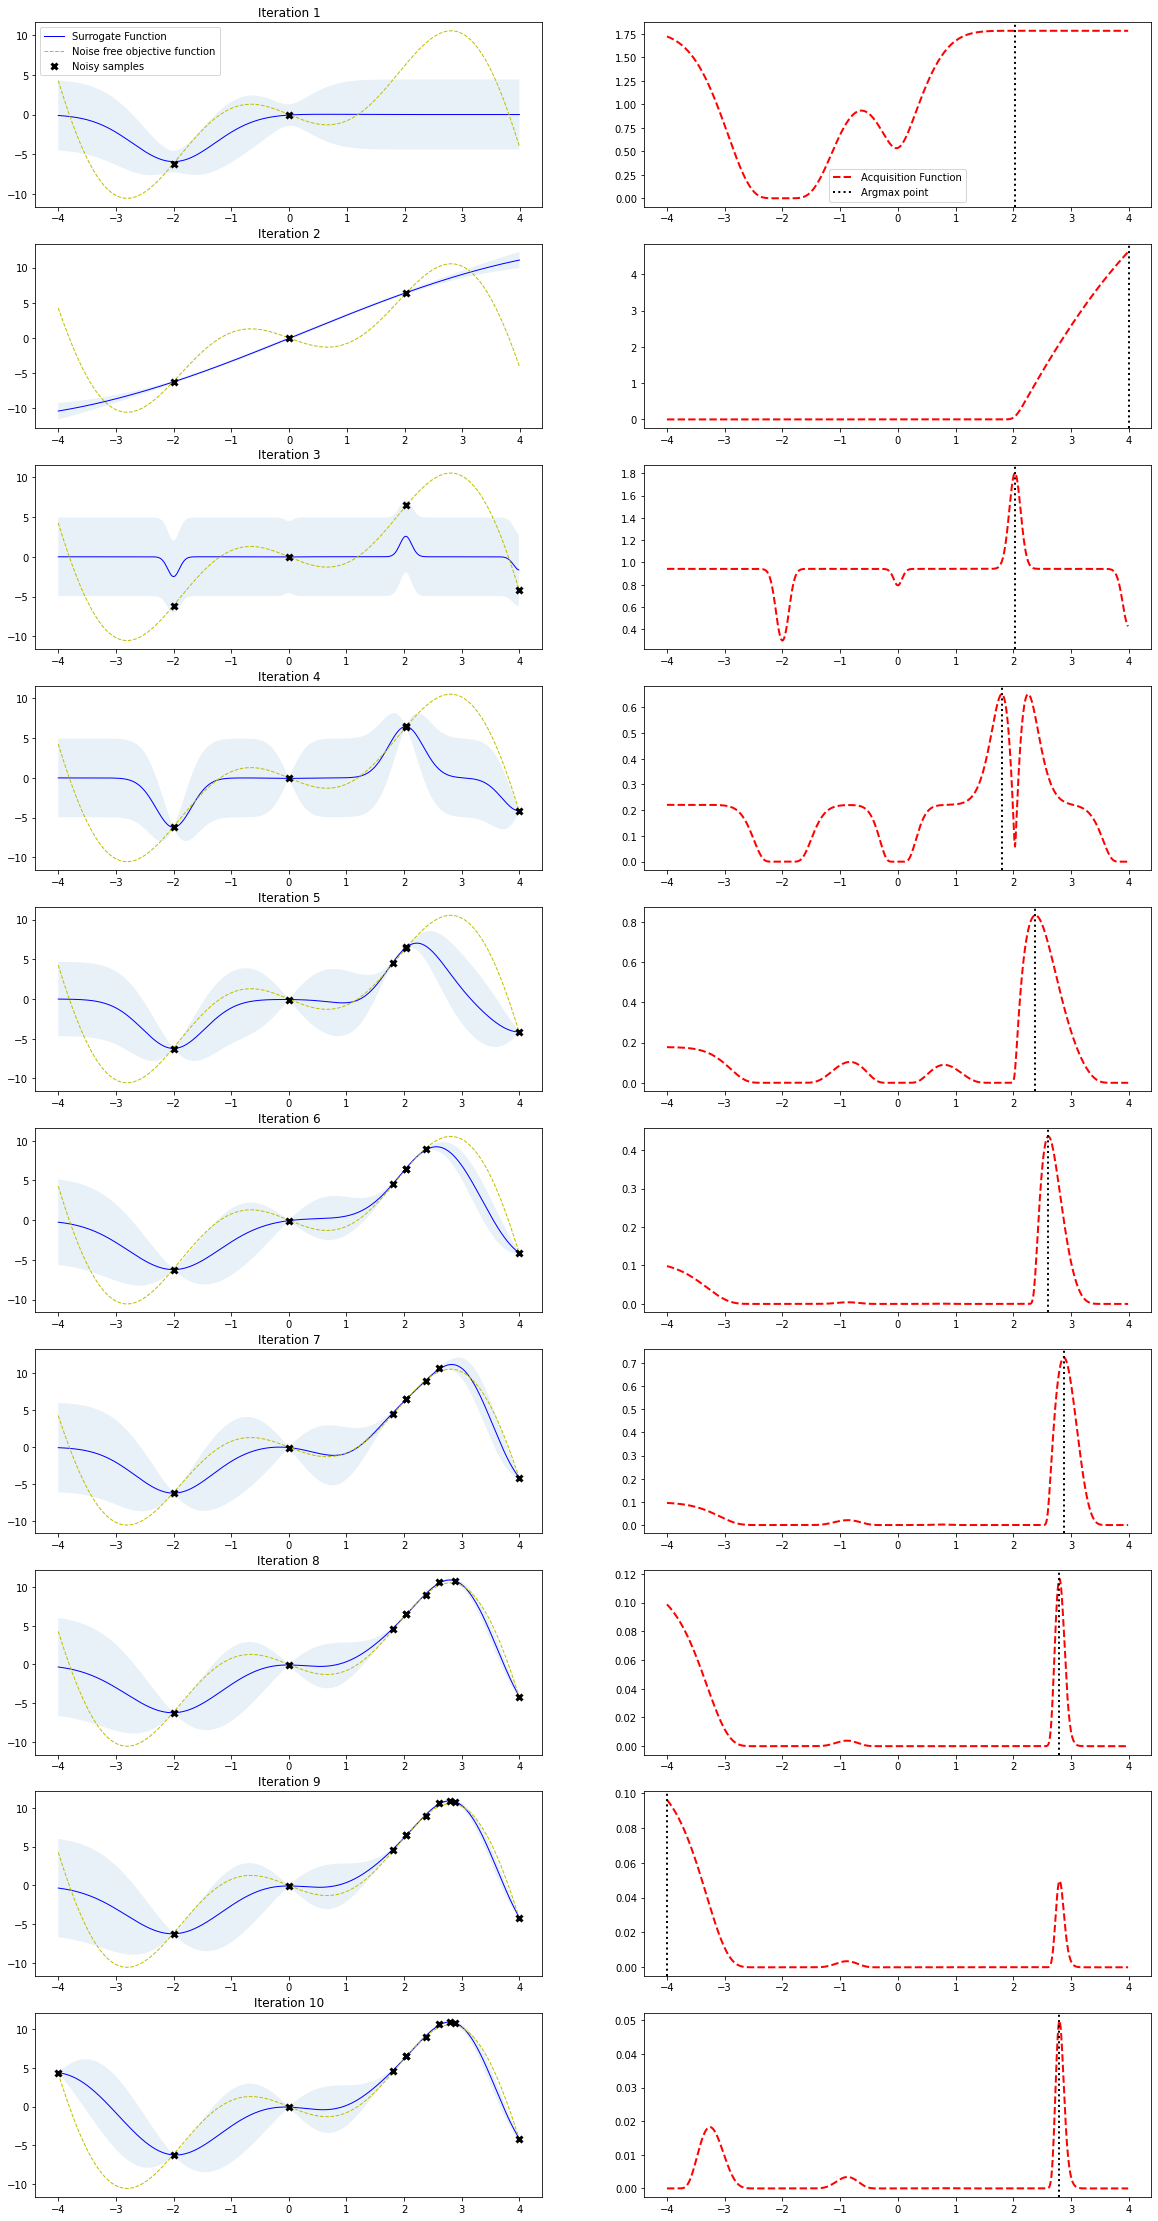

In [ ]:
# Initial point
X_samples = np.array([[-2], [0]])
Y_samples = F(X_samples, noise)

plt.figure(figsize=(20,40))
for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_samples, Y_samples)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_next_sample(expected_improvement, X_samples, Y_samples, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = F(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_gaussian_process(gpr, x_space, F(x_space, 0), X_samples, Y_samples, show_legend=(i==0))
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition_fxn(x_space, expected_improvement(x_space, X_samples, Y_samples, gpr), X_next, show_legend=(i==0))

    # Add sample to previous samples
    X_samples = np.vstack((X_samples, X_next))
    Y_samples = np.vstack((Y_samples, Y_next))

plt.show()